In [1]:
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)

In [2]:
import nltk
from collections import Counter

In [4]:
df = pd.read_csv("data/reviews_cleaned.csv")
df.drop_duplicates(inplace=True)
df = df[df.rating.notna()]
df.rating = df.rating.astype(int)
df.text = df.text.fillna("")
df.plus = df.plus.fillna("")
df.minus = df.minus.fillna("")

In [5]:
df

,text,plus,minus,language,rating,category
0,,бомбезный фен,,russian,5,beauty
1,,хороший фен свой деньги очень приятный цвет,,russian,5,beauty
2,отличный большой фен,четко,нет негатив,russian,5,beauty
3,,мощный самый главный,тонкий шнур,russian,5,beauty
4,,очень сушить волос,,russian,5,beauty
...,...,...,...,...,...,...
199683,,очень нравиться удобно информация,,russian,5,wearables
199684,,купить сегодня часики очень классный удобный и...,,russian,5,wearables
199685,купить два пара браслет довольный покупка,функция работать батарейка долго держаться,единственный звонок высвечиваться не разбирать...,russian,5,wearables
199686,,очень хороший качество все работать отлично,,russian,5,wearables


In [6]:
STOPWORDS = {'и', 'в', 'во', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все',
             'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы',
             'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'о', 'из',
             'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже',
             'или', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж',
             'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они',
             'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем',
             'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе',
             'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого',
             'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем',
             'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда',
             'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над',
             'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая',
             'много', 'разве', 'три', 'эту', 'моя', 'впрочем', 'хорошо', 'свою', 'этой',
             'перед', 'иногда', 'лучше', 'чуть', 'том', 'нельзя', 'такой', 'им',
             'более', 'всегда', 'конечно', 'всю', 'между', 'пока', 'это', 'хотя', 'не', 'нет', 'ни'}
PUNCTUATION = {'$', '=', '_', '?', ')', '*', '[', '(', '{', "'", '\\', ',', ':', ';',
               '|', '+', '`', '.', '<', '@', '%', '#', '"', '^', '&', '>', '}', '~',
               '/', '!', ']', '-', ' ', }


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176364 entries, 0 to 199687
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      176364 non-null  object
 1   plus      176364 non-null  object
 2   minus     176364 non-null  object
 3   language  176364 non-null  object
 4   rating    176364 non-null  int32 
 5   category  176364 non-null  object
dtypes: int32(1), object(5)
memory usage: 8.7+ MB


In [8]:
df.rating.describe()

count    176364.000000
mean          4.671384
std           0.843446
min           1.000000
25%           5.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

In [11]:
df.rating.unique()

array([5, 4, 3, 2, 1])

### Documents initialization

In [10]:
plus_documents = df[df.language == 'russian'].plus
minus_documents = df[df.language == 'russian'].minus
text_documents = df[df.language == 'russian'].text

In [11]:
kaz_plus_documents = df[df.language == 'kazakh'].plus
kaz_minus_documents = df[df.language == 'kazakh'].minus
kaz_text_documents = df[df.language == 'kazakh'].text

## Words Counter

In [12]:
def document_counter(document):
    counter = Counter()
    for review in document:
        for word in review.split():
            if word in STOPWORDS:
                continue
            counter[word] = counter.get(word, 0) + 1
            
    return counter

In [13]:
plus_counts = document_counter(plus_documents)
minus_counts = document_counter(minus_documents)
text_counts = document_counter(text_documents)

In [14]:
kaz_plus_counts = document_counter(kaz_plus_documents)
kaz_minus_counts = document_counter(kaz_minus_documents)
kaz_text_counts = document_counter(kaz_text_documents)

## Bigrams Counter

In [15]:
def bigram_counter(documents):
    bigram_counter = Counter()
    
    for review in documents:
        words = review.split()
        for i, word in enumerate(words):
            if i == 0:
                continue
                
            bigram = f"{words[i-1]} {word}"
            bigram_counter[bigram] = bigram_counter.get(bigram, 0) + 1
    
    return bigram_counter

In [16]:
plus_bigrams = bigram_counter(plus_documents)
minus_bigrams = bigram_counter(minus_documents)
text_bigrams = bigram_counter(text_documents)

In [17]:
kaz_plus_bigrams = bigram_counter(kaz_plus_documents)
kaz_minus_bigrams = bigram_counter(kaz_minus_documents)
kaz_text_bigrams = bigram_counter(kaz_text_documents)

## Visualization

### Positive Comments

In [36]:
bigrams, counts = map(list, zip(*plus_bigrams.most_common(8)))

Text(0.5, 1.0, 'Positive bigrams in Russian')

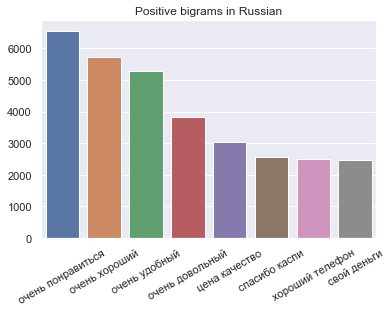

In [48]:
top_words = sns.barplot(x=bigrams, y=counts)
top_words.set_xticklabels(bigrams, rotation=30)
top_words.set_title("Positive bigrams in Russian")

In [20]:
bigrams, counts = map(list, zip(*kaz_plus_bigrams.most_common(8)))

Text(0.5, 1.0, 'Positive bigrams in Kazakh')

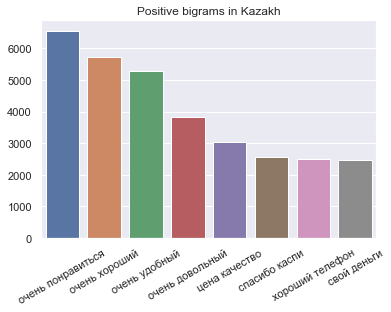

In [47]:
top_words = sns.barplot(x=bigrams, y=counts)
top_words.set_xticklabels(bigrams, rotation=30)
top_words.set_title("Positive bigrams in Kazakh")

### Negative Comments

In [22]:
bigrams, counts = map(list, zip(*minus_bigrams.most_common(8)))

Text(0.5, 1.0, 'Negative bigrams in Russian')

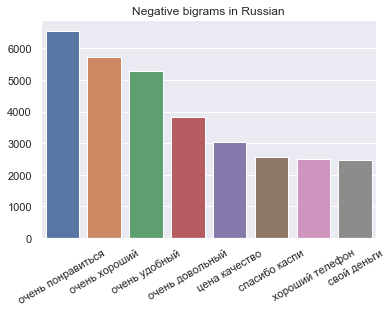

In [46]:
top_words = sns.barplot(x=bigrams, y=counts)
top_words.set_xticklabels(bigrams, rotation=30)
top_words.set_title("Negative bigrams in Russian")

In [50]:
bigrams, counts = map(list, zip(*kaz_minus_bigrams.most_common(8)))

Text(0.5, 1.0, 'Negative bigrams in Kazakh')

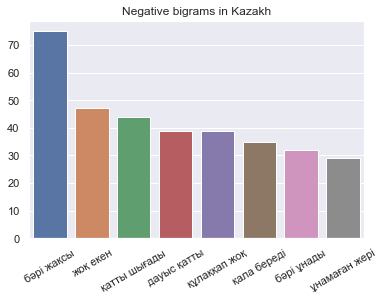

In [51]:
top_words = sns.barplot(x=bigrams, y=counts)
top_words.set_xticklabels(bigrams, rotation=30)
top_words.set_title("Negative bigrams in Kazakh")

### Comments

In [52]:
bigrams, counts = map(list, zip(*text_bigrams.most_common(8)))

Text(0.5, 1.0, 'Comment bigrams in Russian')

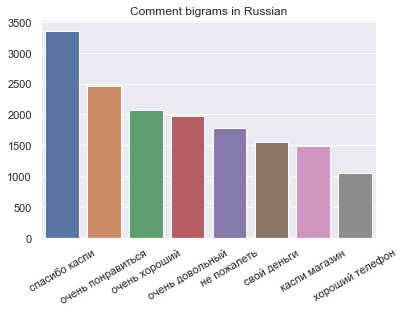

In [53]:
top_words = sns.barplot(x=bigrams, y=counts)
top_words.set_xticklabels(bigrams, rotation=30)
top_words.set_title("Comment bigrams in Russian")

In [28]:
bigrams, counts = map(list, zip(*kaz_text_bigrams.most_common(8)))

Text(0.5, 1.0, 'Comment bigrams in Kazakh')

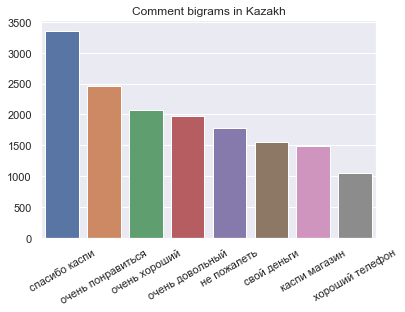

In [54]:
top_words = sns.barplot(x=bigrams, y=counts)
top_words.set_xticklabels(bigrams, rotation=30)
top_words.set_title("Comment bigrams in Kazakh")

### Ratings

In [59]:
ratings, counts = map(list, zip(*Counter(df.rating).items()))

Text(0.5, 1.0, 'Ratings counts')

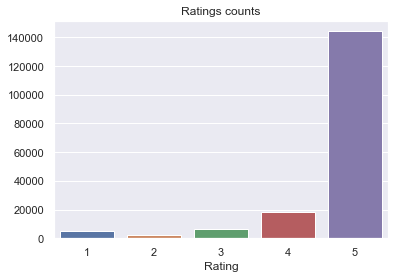

In [60]:
ratings = sns.barplot(x=ratings, y=counts)
ratings.set(xlabel="Rating")
ratings.set_title("Ratings counts")

### Ratings without 5

In [66]:
ratings, counts = map(list, zip(*Counter(df.rating).items()))

Text(0.5, 1.0, 'Ratings without 5')

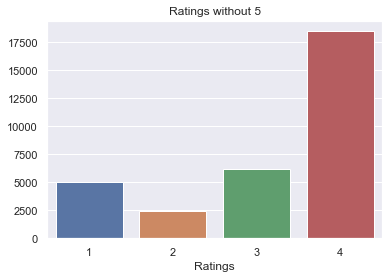

In [67]:
ratings = sns.barplot(x=ratings[1:], y=counts[1:])
ratings.set(xlabel="Ratings")
ratings.set_title("Ratings without 5")